### Normalização das imagens filtered entre 0 e 255

In [79]:
import SimpleITK as sitk
import numpy as np

def normalize_img(image):
    imagem = sitk.ReadImage("images_filtered/IXI002-Guys-0828-T1.nii.gz")
    img_np = sitk.GetArrayFromImage(imagem)

    data_min = np.min(img_np)
    data_max = np.max(img_np)
    normalized_data = (img_np - data_min) / (data_max - data_min) * 255
    normalized_data = normalized_data.astype(np.uint8)
    image_norm = sitk.GetImageFromArray(normalized_data)
    return image_norm
    

### Função

In [2]:
import os
def read_directories(directory, img=None):
    # Get a list of filenames in the specified directory
    filenames = []
    for filename in os.listdir(directory):
        if img is not None:
            # If 'img' is provided, filter filenames containing it
            if img in filename:   
                filenames.append(filename)          
        else:
            filenames.append(filename)    
    return filenames

### Normalizando as imagens filtradas

In [3]:
dir_images = f'images_filtered'
array_images = read_directories(dir_images)
dir_out = f'normalizeds'


for image in array_images:
    path = f'{dir_images}/{image}'
    name_out = f'{dir_out}/{image}'
    image_normalized = normalize_img(path)
    sitk.WriteImage(image_normalized, name_out)
    
    

NameError: name 'normalize_img' is not defined

In [4]:
dir_out = f'normalizeds'
array_normalizeds = read_directories(dir_out)

### Extraindo as médias dos valores de CSF, GM e WM

In [1]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
def calc_means_csf_gm_wm(path):
    #imagem que vai ser usada como teste
    imagem = sitk.ReadImage(f"normalizeds/{path}")
    img_np = sitk.GetArrayFromImage(imagem)


    atlas_csf = sitk.ReadImage(f"atlas_resampled/{path}/mni_csf.nii.gz")
    atlas_gm = sitk.ReadImage(f"atlas_resampled/{path}/mni_gm.nii.gz")
    atlas_wm = sitk.ReadImage(f"atlas_resampled/{path}/mni_wm.nii.gz")

    atlas_csf_array = sitk.GetArrayFromImage(atlas_csf)
    atlas_gm_array = sitk.GetArrayFromImage(atlas_gm)
    atlas_wm_array = sitk.GetArrayFromImage(atlas_wm)

    binary_array_csf = (atlas_csf_array > 0.98).astype(np.uint8)
    binary_array_gm = (atlas_gm_array > 0.98).astype(np.uint8)
    binary_array_wm = (atlas_wm_array > 0.98).astype(np.uint8)

    # Converter de volta para imagem SimpleITK
    binary_image_csf = sitk.GetImageFromArray(binary_array_csf)
    binary_image_csf.CopyInformation(atlas_csf)  # Mantém metadados da imagem original

    binary_image_gm = sitk.GetImageFromArray(binary_array_gm)
    binary_image_gm.CopyInformation(atlas_gm)  # Mantém metadados da imagem original

    binary_image_wm = sitk.GetImageFromArray(binary_array_wm)
    binary_image_wm.CopyInformation(atlas_wm)  # Mantém metadados da imagem original

    mask_np_csf = (binary_array_csf > 0).astype(np.uint8)
    mask_np_gm = (binary_array_gm > 0).astype(np.uint8)
    mask_np_wm = (binary_array_wm > 0).astype(np.uint8)

    result_np_csf = (img_np * mask_np_csf)
    result_np_gm = (img_np * mask_np_gm)
    result_np_wm = (img_np * mask_np_wm)

    vetor_np_csf = result_np_csf[result_np_csf>0]
    vetor_np_csf_mean = np.mean(vetor_np_csf)
    print(f"Vetor final média csf: {vetor_np_csf_mean}.")

    vetor_np_gm = result_np_gm[result_np_gm>0]
    vetor_np_gm_mean = np.mean(vetor_np_gm)
    print(f"Vetor final média gm: {vetor_np_gm_mean}.")


    vetor_np_wm = result_np_wm[result_np_wm>0]
    vetor_np_wm_mean = np.mean(vetor_np_wm)
    print(f"Vetor final média wm: {vetor_np_wm_mean}.")


    dict = {
        'CSF':vetor_np_csf_mean,
        'GM':vetor_np_gm_mean,
        'WM':vetor_np_wm_mean,
        'vetor_np_csf':vetor_np_csf,
        'vetor_np_gm':vetor_np_gm,
        'vetor_np_wm':vetor_np_wm,
    }
    return dict


### Usando o kmeans com as três médias advindas das imagens. 

In [ ]:
dir_output_segmented = f'segmenteds'

for image in array_normalizeds:
    # --- Carregar a imagem original ---
    image_path = f"normalizeds\{image}"  # Modifique para o caminho da sua imagem
    nifti_image = nib.load(image_path)
    image_data = nifti_image.get_fdata()  # Array NumPy da imagem

    # --- Carregar a máscara ---
    mask_path = f"atlas_resampled\{image}\mni_mask.nii.gz"  # Caminho do arquivo enviado
    mask_nifti = nib.load(mask_path)
    mask_data = mask_nifti.get_fdata()  # Array NumPy da máscara

    # --- Aplicar a máscara (mantendo apenas a parte branca) ---
    image_data[mask_data == 0] = 0

    # Obter o tamanho do voxel em mm (dimensão do voxel)
    voxel_size = np.prod(nifti_image.header.get_zooms())  # Multiplica (dx, dy, dz) para obter mm³

    dicionario = calc_means_csf_gm_wm(image)
    vetor_np_csf_mean = dicionario['CSF']
    print(f'vetor_np_csf_mean: {vetor_np_csf_mean}')

    vetor_np_gm_mean = dicionario['GM']
    print(f'vetor_np_gm_mean: {vetor_np_gm_mean}')
    
    vetor_np_wm_mean = dicionario['WM']
    print(f'vetor_np_wm_mean: {vetor_np_wm_mean}')

    # Definir as médias fornecidas para os 3 clusters
    cluster_means = np.array([[vetor_np_csf_mean], [vetor_np_gm_mean], [vetor_np_wm_mean]])  # Exemplo de valores médios

    # Número de clusters
    k = len(cluster_means)

    # Inicializar centroides com as médias fornecidas
    centroids = cluster_means.copy()

    # Função para atribuir cada pixel ao cluster mais próximo
    def assign_to_cluster(image_data, centroids):
        distances = np.abs(image_data[..., None] - centroids.flatten())
        return np.argmin(distances, axis=-1)

    # Função para atualizar os centroids
    def update_centroids(image_data, labels, k):
        new_centroids = np.zeros(k)
        for i in range(k):
            if np.any(labels == i):
                new_centroids[i] = np.mean(image_data[labels == i])
            else:
                new_centroids[i] = centroids[i]  # Mantém se não houver atualização
                print(f'centroid[i]: {centroids[i]}')
        return new_centroids

    # Número máximo de iterações
    max_iters = 100
    tolerance = 1e-4
    prev_centroids = np.zeros_like(centroids)

    # Iteração do K-means
    for iteration in range(max_iters):
        labels = assign_to_cluster(image_data, centroids)
        centroids = update_centroids(image_data, labels, k)
        
        if np.all(np.abs(centroids - prev_centroids) < tolerance):
            print(f"Convergência atingida após {iteration + 1} iterações.")
            break
        
        prev_centroids = centroids.copy()

    # Criar uma imagem RGB para visualização
    segmented_rgb = np.zeros((*labels.shape, 3), dtype=np.uint8)

    # Definir as cores (R, G, B)
    colors = {
        0: [255, 0, 0],      # Vermelho (Primeira classe)
        1: [128, 128, 128],      # Cinza (Segunda classe)
        2: [255, 255, 255],  # Branco (Terceira classe)       
    }

    # Atribuir cores aos pixels classificados
    for class_id, color in colors.items():
        segmented_rgb[labels == class_id] = color

    # Aplicar a máscara na segmentação (fundo preto)
    segmented_rgb[mask_data == 0] = [0, 0, 0]

    # Mostrar um corte da segmentação
    slice_index = segmented_rgb.shape[0] // 2  # Pegar um corte no meio
    plt.figure(figsize=(8, 6))
    plt.imshow(segmented_rgb[slice_index])  # Mostrar a imagem colorida
    plt.title("Segmentação K-means com máscara aplicada")
    plt.axis("off")
    plt.show()
    #nib.save(segmented_rgb,filename='segmented_rgb.nii.gz')

    # --- Cálculo do Volume ---
    volumes = {}
    for class_id in range(k):
        num_voxels = np.sum(labels == class_id)  # Contar número de voxels na classe
        volume_mm3 = num_voxels * voxel_size  # Multiplicar pelo tamanho do voxel
        volumes[class_id] = volume_mm3

    # Exibir resultados
    print("\nVolumes calculados:")
    for class_id, volume in volumes.items():
        print(f"Classe {class_id} ({['CSF', 'GM', 'WM'][class_id]}): {volume:.2f} mm³")

    segmented_nifti = nib.Nifti1Image(segmented_rgb, affine=nifti_image.affine, header=nifti_image.header)

    
    # --- Salvar a imagem segmentada ---
    nib.save(segmented_nifti, f'{dir_output_segmented}/{image}')

### Usando o Kmeans com valores setados

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os

#def calc_means_csf_gm_wm(image):
    #return {'CSF': 104, 'GM': 64, 'WM': 40}

dir_output_segmented = 'segmenteds'

for i in range(1):
    image_path = f"normalizeds/{array_normalizeds[0]}"
    mask_path = f"atlas_resampled/{array_normalizeds[0]}/mni_mask.nii.gz"

    nifti_image = nib.load(image_path)
    image_data = nifti_image.get_fdata()
    
    mask_nifti = nib.load(mask_path)
    mask_data = mask_nifti.get_fdata()
    
    image_data[mask_data == 0] = 0
    voxel_size = np.prod(nifti_image.header.get_zooms())
    
    dicionario = calc_means_csf_gm_wm(array_normalizeds[0])
    cluster_means = np.array([dicionario['CSF'], dicionario['GM'], dicionario['WM'], 0])
    print(f'cluster_means: {cluster_means}')
    k = len(cluster_means)
    centroids = cluster_means.copy()
    
    def assign_to_cluster(image_data, centroids):
        distances = np.abs(image_data[..., None] - centroids.flatten())
        return np.argmin(distances, axis=-1)
    
    def update_centroids(image_data, labels, k):
        new_centroids = np.zeros(k)
        for i in range(k):
            if np.any(labels == i):
                new_centroids[i] = np.mean(image_data[labels == i])
            else:
                new_centroids[i] = centroids[i]
        return new_centroids
    
    max_iters = 100
    tolerance = 1e-4
    prev_centroids = np.zeros_like(centroids)
    
    for iteration in range(max_iters):
        labels = assign_to_cluster(image_data, centroids)
        centroids = update_centroids(image_data, labels, k)
        
        if np.all(np.abs(centroids - prev_centroids) < tolerance):
            break
        prev_centroids = centroids.copy()
    
    segmented_rgb = np.zeros((*labels.shape, 4), dtype=np.uint8)
    colors = {
        0: [255, 0, 0, 255],      # Vermelho (Primeira classe)
        1: [128, 128, 128, 255],  # Cinza (Segunda classe)
        2: [255, 255, 255, 255],  # Branco (Terceira classe)
        3: [0, 255, 0, 255]       # Verde (Quarta classe - lixo)
    }
    
    for class_id, color in colors.items():
        segmented_rgb[labels == class_id] = color
    
    segmented_rgb[mask_data == 0] = [0, 0, 0, 0]
    
    slice_index = segmented_rgb.shape[0] // 2
    plt.figure(figsize=(8, 6))
    plt.imshow(segmented_rgb[slice_index])
    plt.title("Segmentação K-means com máscara aplicada")
    plt.axis("off")
    plt.show()
    
    volumes = {}
    for class_id in range(k):
        num_voxels = np.sum(labels == class_id)
        volume_mm3 = num_voxels * voxel_size
        volumes[class_id] = volume_mm3
    
    print("\nVolumes calculados:")
    for class_id, volume in volumes.items():
        print(f"Classe {class_id} ({['CSF', 'GM', 'WM', 'lixo'][class_id]}): {volume:.2f} mm³")
    
    segmented_nifti = nib.Nifti1Image(segmented_rgb, affine=nifti_image.affine, header=nifti_image.header)
    os.makedirs(dir_output_segmented, exist_ok=True)
    nib.save(segmented_nifti, f'{dir_output_segmented}/{array_normalizeds[0]}')



### Usando o Kmeans++ com imagens normalizadas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

# --- Carregar a imagem original ---
image_path = "normalizeds\IXI002-Guys-0828-T1.nii.gz"  
nifti_image = nib.load(image_path)
image_data = nifti_image.get_fdata()

# --- Carregar a máscara ---
mask_path = "atlas_resampled\IXI002-Guys-0828-T1.nii.gz\mni_mask.nii.gz"
mask_nifti = nib.load(mask_path)
mask_data = mask_nifti.get_fdata()

# --- Aplicar a máscara (mantendo apenas a parte branca) ---
image_data[mask_data == 0] = 0

# Obter o tamanho do voxel em mm³ (dimensão do voxel)
voxel_size = np.prod(nifti_image.header.get_zooms())

# Número de clusters (3 classes + 1 classe "lixo")
k = 4

# --- Inicialização dos centróides com K-means++ ---
def initialize_kmeans_pp(data, k):
    """
    Inicializa os centróides usando o método K-means++
    """
    data_flat = data[mask_data > 0].flatten()  # Apenas valores dentro da máscara
    centroids = [np.random.choice(data_flat)]  # Escolher o primeiro aleatoriamente
    print(f' centroid inicial: { centroids}')
    
    for _ in range(1, k - 1):  # Deixar uma classe reservada para valores próximos de zero
        distances = np.min([np.abs(data_flat - c) for c in centroids], axis=0)
        probabilities = distances ** 2  # Quanto maior a distância, maior a chance de escolha
        probabilities /= np.sum(probabilities)  # Normalizar
        
        new_centroid = np.random.choice(data_flat, p=probabilities)
        centroids.append(new_centroid)
    
    centroids.append(0)  # Classe "lixo" para valores próximos de zero
    
    return np.array(centroids)

# Inicializa os centróides
centroids = initialize_kmeans_pp(image_data, k)

# --- Função para atribuir cada pixel ao cluster mais próximo ---
def assign_to_cluster(image_data, centroids):
    distances = np.abs(image_data[..., None] - centroids.flatten())
    return np.argmin(distances, axis=-1)

# --- Função para atualizar os centroids ---
def update_centroids(image_data, labels, k):
    new_centroids = np.zeros(k)
    for i in range(k):
        if np.any((labels == i) & (mask_data > 0)) and i != k - 1:  # Apenas valores dentro da máscara
            new_centroids[i] = np.mean(image_data[(labels == i) & (mask_data > 0)])
            print(f' new_centroids {[i]}: { new_centroids[i]}')
        else:
            new_centroids[i] = centroids[i]  # Mantém o valor se não houver atualização
            print(f'centroids {[i]}: {centroids[i]}')
            print(f' new_centroids {[i]}: { new_centroids[i]}')
    return new_centroids
 

# Número máximo de iterações
max_iters = 100
tolerance = 1e-4
prev_centroids = np.zeros_like(centroids)

# --- Iteração do K-means ---
for iteration in range(max_iters):
    labels = assign_to_cluster(image_data, centroids)
    centroids = update_centroids(image_data, labels, k)
    
    if np.all(np.abs(centroids - prev_centroids) < tolerance):
        print(f"Convergência atingida após {iteration + 1} iterações.")
        break
    
    prev_centroids = centroids.copy()

# Criar uma imagem RGB para visualização
segmented_rgb = np.zeros((*labels.shape, 3), dtype=np.uint8)

# Definir as cores (R, G, B)
colors = {
    0: [255, 0, 0],      # CSF
    1: [128, 128, 128],      # GM
    2: [255, 255, 255],  # WM
    3: [0, 0,  0],  # Preto
}

# Atribuir cores aos pixels classificados
for class_id, color in colors.items():
    segmented_rgb[labels == class_id] = color

# Aplicar a máscara na segmentação (fundo preto)
segmented_rgb[mask_data == 0] = [0, 0, 0]

# Mostrar um corte da segmentação
slice_index = segmented_rgb.shape[0] // 2
plt.figure(figsize=(8, 6))
plt.imshow(segmented_rgb[slice_index])
plt.title("Segmentação K-means++ com máscara aplicada")
plt.axis("off")
plt.show()

# --- Cálculo do Volume ---
volumes = {}
for class_id in range(k):
    num_voxels = np.sum((labels == class_id) & (mask_data > 0))
    volume_mm3 = num_voxels * voxel_size
    volumes[class_id] = volume_mm3

# Exibir resultados
print("\nVolumes calculados:")
for class_id, volume in volumes.items():
    print(f"Classe {class_id} ({['CSF', 'GM', 'WM', 'Preto'][class_id]}): {volume:.2f} mm³")


### Usando o Kmeans++ com imagens sem normalização

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

# --- Carregar a imagem original ---
image_path = "images_filtered\IXI002-Guys-0828-T1.nii.gz"  
nifti_image = nib.load(image_path)
image_data = nifti_image.get_fdata()

# --- Carregar a máscara ---
mask_path = "atlas_resampled\IXI002-Guys-0828-T1.nii.gz\mni_mask.nii.gz"
mask_nifti = nib.load(mask_path)
mask_data = mask_nifti.get_fdata()

# --- Aplicar a máscara (mantendo apenas a parte branca) ---
image_data[mask_data == 0] = 0

# Obter o tamanho do voxel em mm³ (dimensão do voxel)
voxel_size = np.prod(nifti_image.header.get_zooms())

# Número de clusters (3 classes + 1 classe "lixo")
k = 4

# --- Inicialização dos centróides com K-means++ ---
def initialize_kmeans_pp(data, k):
    """
    Inicializa os centróides usando o método K-means++
    """
    data_flat = data[mask_data > 0].flatten()  # Apenas valores dentro da máscara
    centroids = [np.random.choice(data_flat)]  # Escolher o primeiro aleatoriamente
    print(f' centroid inicial: { centroids}')
    
    for _ in range(1, k - 1):  # Deixar uma classe reservada para valores próximos de zero
        distances = np.min([np.abs(data_flat - c) for c in centroids], axis=0)
        probabilities = distances ** 2  # Quanto maior a distância, maior a chance de escolha
        probabilities /= np.sum(probabilities)  # Normalizar
        
        new_centroid = np.random.choice(data_flat, p=probabilities)
        centroids.append(new_centroid)
    
    centroids.append(0)  # Classe "lixo" para valores próximos de zero
    
    return np.array(centroids)

# Inicializa os centróides
centroids = initialize_kmeans_pp(image_data, k)

# --- Função para atribuir cada pixel ao cluster mais próximo ---
def assign_to_cluster(image_data, centroids):
    distances = np.abs(image_data[..., None] - centroids.flatten())
    return np.argmin(distances, axis=-1)

# --- Função para atualizar os centroids ---
def update_centroids(image_data, labels, k):
    new_centroids = np.zeros(k)
    for i in range(k):
        if np.any((labels == i) & (mask_data > 0)) and i != k - 1:  # Apenas valores dentro da máscara
            new_centroids[i] = np.mean(image_data[(labels == i) & (mask_data > 0)])
            print(f' new_centroids {[i]}: { new_centroids[i]}')
        else:
            new_centroids[i] = centroids[i]  # Mantém o valor se não houver atualização
            print(f'centroids {[i]}: {centroids[i]}')
            print(f' new_centroids {[i]}: { new_centroids[i]}')
    return new_centroids
 

# Número máximo de iterações
max_iters = 100
tolerance = 1e-4
prev_centroids = np.zeros_like(centroids)

# --- Iteração do K-means ---
for iteration in range(max_iters):
    labels = assign_to_cluster(image_data, centroids)
    centroids = update_centroids(image_data, labels, k)
    
    if np.all(np.abs(centroids - prev_centroids) < tolerance):
        print(f"Convergência atingida após {iteration + 1} iterações.")
        break
    
    prev_centroids = centroids.copy()

# Criar uma imagem RGB para visualização
segmented_rgb = np.zeros((*labels.shape, 3), dtype=np.uint8)

# Definir as cores (R, G, B)
colors = {
    0: [255, 0, 0],      # CSF
    1: [128, 128, 128],      # GM
    2: [255, 255, 255],  # WM
    3: [0, 0,  0],  # Preto
}

# Atribuir cores aos pixels classificados
for class_id, color in colors.items():
    segmented_rgb[labels == class_id] = color

# Aplicar a máscara na segmentação (fundo preto)
segmented_rgb[mask_data == 0] = [0, 0, 0]

# Mostrar um corte da segmentação
slice_index = segmented_rgb.shape[0] // 2
plt.figure(figsize=(8, 6))
plt.imshow(segmented_rgb[slice_index])
plt.title("Segmentação K-means++ com máscara aplicada")
plt.axis("off")
plt.show()

# --- Cálculo do Volume ---
volumes = {}
for class_id in range(k):
    num_voxels = np.sum((labels == class_id) & (mask_data > 0))
    volume_mm3 = num_voxels * voxel_size
    volumes[class_id] = volume_mm3

# Exibir resultados
print("\nVolumes calculados:")
for class_id, volume in volumes.items():
    print(f"Classe {class_id} ({['CSF', 'GM', 'WM', 'Preto'][class_id]}): {volume:.2f} mm³")

### Comparação dos resultados obtidos

In [ ]:
'''Imagem sem normalização
Volumes calculados:
Classe 0 (CSF): 612731.84 mm³
Classe 1 (GM): 275177.83 mm³
Classe 2 (WM): 681555.30 mm³
Classe 3 (Preto): 197074.20 mm³

Volumes calculados:
Classe 0 (CSF): 612731.84 mm³
Classe 1 (GM): 275177.83 mm³
Classe 2 (WM): 681555.30 mm³
Classe 3 (Preto): 197074.20 mm³

Volumes calculados:
Classe 0 (CSF): 681555.30 mm³
Classe 1 (GM): 612731.84 mm³
Classe 2 (WM): 275177.83 mm³
Classe 3 (Preto): 197074.20 mm³


Imagem com normalização
Volumes calculados:
Classe 0 (CSF): 595731.00 mm³
Classe 1 (GM): 248577.00 mm³
Classe 2 (Rosa): 643773.00 mm³
Classe 3 (Preto): 186864.00 mm³

Volumes calculados:
Classe 0 (CSF): 595731.00 mm³
Classe 1 (GM): 248577.00 mm³
Classe 2 (WM): 643773.00 mm³
Classe 3 (Preto): 186864.00 mm³

Volumes calculados:
Classe 0 (CSF): 595731.00 mm³
Classe 1 (GM): 248577.00 mm³
Classe 2 (WM): 643773.00 mm³
Classe 3 (Preto): 186864.00 mm³

Volumes calculados:
Classe 0 (CSF): 643773.00 mm³
Classe 1 (GM): 248577.00 mm³
Classe 2 (WM): 595731.00 mm³
Classe 3 (Preto): 186864.00 mm³

Volumes calculados:
Classe 0 (CSF): 595731.00 mm³
Classe 1 (GM): 248577.00 mm³
Classe 2 (WM): 643773.00 mm³
Classe 3 (Preto): 186864.00 mm³'''

In [ ]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.ndimage import label

def load_nifti(file_path):
    nii = nib.load(file_path)
    data = nii.get_fdata()
    voxel_volume = np.prod(nii.header.get_zooms())  # Volume de um único voxel
    return data, voxel_volume

def segment_gmm(image, mask, n_components=3):
    """Segmenta a imagem dentro da máscara usando GMM com n componentes."""
    masked_data = image[mask > 0].reshape(-1, 1)
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(masked_data)
    labels = gmm.predict(masked_data)
    
    segmented = np.zeros_like(image, dtype=int)
    segmented[mask > 0] = labels
    return segmented

def calculate_volumes(segmented_image, mask, voxel_volume):
    """Calcula o volume de cada segmento dentro da máscara na imagem."""
    unique_labels = np.unique(segmented_image[mask > 0])
    volumes = {}
    for label in unique_labels:
        count = np.sum(segmented_image == label)
        volumes[label] = count * voxel_volume  # Volume total da região
    return volumes

def plot_slice(image, segmented, mask, slice_idx):
    """Plota um corte da imagem original e segmentada dentro da máscara."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image[:, :, slice_idx], cmap='gray')
    axes[0].set_title("Imagem Original")
    
    axes[1].imshow(mask[:, :, slice_idx], cmap='gray')
    axes[1].set_title("Máscara")
    
    axes[2].imshow(segmented[:, :, slice_idx], cmap='viridis')
    axes[2].set_title("Segmentação GMM")
    plt.show()

# Exemplo de uso
file_path = "normalizeds\IXI002-Guys-0828-T1.nii.gz"  # Substituir pelo caminho do arquivo
mask_path = "atlas_resampled\IXI002-Guys-0828-T1.nii.gz\mni_mask.nii.gz"  # Substituir pelo caminho da máscara

image, voxel_vol = load_nifti(file_path)
mask, _ = load_nifti(mask_path)

segmented = segment_gmm(image, mask, n_components=3)
volumes = calculate_volumes(segmented, mask, voxel_vol)

print("Volumes Segmentados:")
for label, vol in volumes.items():
    print(f"Segmento {label}: {vol:.2f} mm³")

# Exibir um corte da imagem
plot_slice(image, segmented, mask, slice_idx=image.shape[2] // 2)



In [ ]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.ndimage import label
from sklearn.cluster import KMeans

def save_segmented_image(segmented_image, output_path, original_image_path):
    """Salva a imagem segmentada no formato .nii.gz com cores específicas."""
    nii_original = nib.load(original_image_path)
    
    # Criando uma imagem colorida
    colored_image = np.zeros((*segmented_image.shape, 3), dtype=np.uint8)
    colored_image[segmented_image == 0] = [0, 0, 0]      # Fundo preto
    colored_image[segmented_image == 1] = [0, 255, 0]    # CSF - Verde
    colored_image[segmented_image == 2] = [128, 128, 128] # GM - Cinza
    colored_image[segmented_image == 3] = [255, 255, 255] # WM - Branco
    
    # Criar objeto NIfTI
    segmented_nii = nib.Nifti1Image(colored_image, nii_original.affine, nii_original.header)
    nib.save(segmented_nii, output_path)
    print(f"Imagem segmentada salva em {output_path}")

def load_nifti(file_path):
    nii = nib.load(file_path)
    data = nii.get_fdata()
    voxel_volume = np.prod(nii.header.get_zooms())
    return data, voxel_volume

def segment_gmm_with_kmeans(image, mask, n_components=3):
    """Segmenta a imagem dentro da máscara usando GMM com KMeans++ para inicialização."""
    masked_data = image[mask > 0].reshape(-1, 1)
    
    kmeans = KMeans(n_clusters=n_components, init='k-means++', random_state=42)
    kmeans.fit(masked_data)
    
    gmm = GaussianMixture(n_components=n_components, init_params='kmeans', means_init=kmeans.cluster_centers_, random_state=42)
    gmm.fit(masked_data)
    
    labels = gmm.predict(masked_data)
    segmented = np.zeros_like(image, dtype=int)
    segmented[mask > 0] = labels + 1  # Ajustar para que CSF seja 1, GM seja 2 e WM seja 3
    
    return segmented

def calculate_volumes(segmented_image, mask, voxel_volume):
    """Calcula o volume de cada segmento dentro da máscara na imagem."""
    unique_labels = np.unique(segmented_image)
    volumes = {}
    
    for label in unique_labels:
        count = np.sum((segmented_image == label) & (mask > 0))
        volumes[label] = count * voxel_volume
        
    return volumes

def plot_slice(image, segmented, mask, slice_idx):
    """Plota um corte da imagem original e segmentada dentro da máscara."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image[:, :, slice_idx], cmap='gray')
    axes[0].set_title("Imagem Original")
    
    axes[1].imshow(mask[:, :, slice_idx], cmap='gray')
    axes[1].set_title("Máscara")
    
    color_map = np.zeros((*segmented.shape, 3), dtype=np.uint8)
    color_map[segmented == 1] = [0, 255, 0]  # CSF - Verde
    color_map[segmented == 2] = [128, 128, 128] # GM - Cinza
    color_map[segmented == 3] = [255, 255, 255] # WM - Branco
    
    axes[2].imshow(color_map[:, :, slice_idx])
    axes[2].set_title("Segmentação GMM")
    plt.show()

# Exemplo de uso
file_path = "normalizeds/IXI002-Guys-0828-T1.nii.gz"
mask_path = "atlas_resampled/IXI002-Guys-0828-T1.nii.gz/mni_mask.nii.gz"

image, voxel_vol = load_nifti(file_path)
mask, _ = load_nifti(mask_path)

segmented = segment_gmm_with_kmeans(image, mask, n_components=3)
volumes = calculate_volumes(segmented, mask, voxel_vol)

output_path = "imagem_segmentada.nii.gz"
save_segmented_image(segmented, output_path, file_path)

print("Volumes Segmentados:")
for label, vol in volumes.items():
    print(f"Segmento {label}: {vol:.2f} mm³")

plot_slice(image, segmented, mask, slice_idx=image.shape[2] // 2)



In [ ]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.ndimage import label
from sklearn.cluster import KMeans

def save_segmented_image(segmented_image, output_path, original_image_path):
    """Salva a imagem segmentada no formato .nii.gz com cores específicas."""
    nii_original = nib.load(original_image_path)
    
    # Criando uma imagem colorida
    colored_image = np.zeros((*segmented_image.shape, 3), dtype=np.uint8)
    colored_image[segmented_image == 0] = [0, 0, 0]      # Fundo preto
    colored_image[segmented_image == 1] = [0, 255, 0]    # CSF - Verde
    colored_image[segmented_image == 2] = [128, 128, 128] # GM - Cinza
    colored_image[segmented_image == 3] = [255, 255, 255] # WM - Branco
    
    # Criar objeto NIfTI
    segmented_nii = nib.Nifti1Image(colored_image, nii_original.affine, nii_original.header)
    nib.save(segmented_nii, output_path)
    print(f"Imagem segmentada salva em {output_path}")

def load_nifti(file_path):
    nii = nib.load(file_path)
    data = nii.get_fdata()
    voxel_volume = np.prod(nii.header.get_zooms())
    return data, voxel_volume

def segment_gmm_with_kmeans(image, mask, n_components=3):
    """Segmenta a imagem dentro da máscara usando GMM com KMeans++ para inicialização."""
    masked_data = image[mask > 0].reshape(-1, 1)
    
    kmeans = KMeans(n_clusters=n_components, init='k-means++', random_state=42)
    kmeans.fit(masked_data)
    
    gmm = GaussianMixture(n_components=n_components, init_params='kmeans', means_init=kmeans.cluster_centers_, random_state=42)
    gmm.fit(masked_data)
    
    labels = gmm.predict(masked_data)
    segmented = np.zeros_like(image, dtype=int)
    segmented[mask > 0] = labels + 1  # Ajustar para que CSF seja 1, GM seja 2 e WM seja 3
    
    return segmented

def refine_with_prob_maps(segmented_image, prob_maps):
    """Ajusta os rótulos da segmentação com base nos mapas probabilísticos."""
    refined_segmentation = np.zeros_like(segmented_image)
    mask = np.sum(prob_maps, axis=0) > 0  # Máscara onde há probabilidade definida
    
    # Para cada voxel dentro da máscara, atribuir a classe com maior probabilidade
    refined_segmentation[mask] = np.argmax(prob_maps[:, mask], axis=0) + 1  # Ajuste para classes 1,2,3
    
    return refined_segmentation

def calculate_volumes(segmented_image, mask, voxel_volume):
    """Calcula o volume de cada segmento dentro da máscara na imagem."""
    unique_labels = np.unique(segmented_image)
    volumes = {}
    
    for label in unique_labels:
        count = np.sum((segmented_image == label) & (mask > 0))
        volumes[label] = count * voxel_volume
        
    return volumes

def plot_slice(image, segmented, mask, slice_idx):
    """Plota um corte da imagem original e segmentada dentro da máscara."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image[:, :, slice_idx], cmap='gray')
    axes[0].set_title("Imagem Original")
    
    axes[1].imshow(mask[:, :, slice_idx], cmap='gray')
    axes[1].set_title("Máscara")
    
    color_map = np.zeros((*segmented.shape, 3), dtype=np.uint8)
    color_map[segmented == 1] = [0, 0, 0]  # CSF - Verde
    color_map[segmented == 2] = [128, 128, 128] # GM - Cinza
    color_map[segmented == 3] = [255, 255, 255] # WM - Branco
    
    axes[2].imshow(color_map[:, :, slice_idx])
    axes[2].set_title("Segmentação Refinada")
    plt.show()

# Exemplo de uso
file_path = "normalizeds/IXI002-Guys-0828-T1.nii.gz"
mask_path = "atlas_resampled/IXI002-Guys-0828-T1.nii.gz/mni_mask.nii.gz"
prob_map_paths = ["atlas_resampled\IXI002-Guys-0828-T1.nii.gz\mni_csf.nii.gz", 
                  "atlas_resampled\IXI002-Guys-0828-T1.nii.gz\mni_gm.nii.gz", 
                  "atlas_resampled\IXI002-Guys-0828-T1.nii.gz\mni_wm.nii.gz"]

image, voxel_vol = load_nifti(file_path)
mask, _ = load_nifti(mask_path)
prob_maps = np.array([load_nifti(p)[0] for p in prob_map_paths])

segmented = segment_gmm_with_kmeans(image, mask, n_components=3)
refined_segmented = refine_with_prob_maps(segmented, prob_maps)
volumes = calculate_volumes(refined_segmented, mask, voxel_vol)

output_path = "imagem_segmentada.nii.gz"
save_segmented_image(refined_segmented, output_path, file_path)

print("Volumes Segmentados:")
for label, vol in volumes.items():
    print(f"Segmento {label}: {vol:.2f} mm³")

plot_slice(image, refined_segmented, mask, slice_idx=image.shape[2] // 2)


In [ ]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.ndimage import label
from sklearn.cluster import KMeans

def save_segmented_image(segmented_image, output_path, original_image_path):
    """Salva a imagem segmentada no formato .nii.gz com cores específicas."""
    nii_original = nib.load(original_image_path)
    
    # Criando uma imagem colorida
    colored_image = np.zeros((*segmented_image.shape, 3), dtype=np.uint8)
    colored_image[segmented_image == 0] = [0, 0, 0]      # Fundo preto
    colored_image[segmented_image == 1] = [0, 255, 0]    # CSF - Verde
    colored_image[segmented_image == 2] = [128, 128, 128] # GM - Cinza
    colored_image[segmented_image == 3] = [255, 255, 255] # WM - Branco
    
    # Criar objeto NIfTI
    segmented_nii = nib.Nifti1Image(colored_image, nii_original.affine, nii_original.header)
    nib.save(segmented_nii, output_path)
    print(f"Imagem segmentada salva em {output_path}")

def load_nifti(file_path):
    nii = nib.load(file_path)
    data = nii.get_fdata()
    voxel_volume = np.prod(nii.header.get_zooms())
    return data, voxel_volume

def segment_gmm_with_kmeans(image, mask, n_components=3):
    """Segmenta a imagem dentro da máscara usando GMM com KMeans++ para inicialização."""
    masked_data = image[mask > 0].reshape(-1, 1)
    
    kmeans = KMeans(n_clusters=n_components, init='k-means++', random_state=42)
    kmeans.fit(masked_data)
    
    gmm = GaussianMixture(n_components=n_components, init_params='kmeans', means_init=kmeans.cluster_centers_, covariance_type='tied', n_init=10, random_state=42)
    gmm.fit(masked_data)
    
    labels = gmm.predict(masked_data)
    segmented = np.zeros_like(image, dtype=int)
    segmented[mask > 0] = labels + 1  # Ajustar para que CSF seja 1, GM seja 2 e WM seja 3
    
    return segmented

def refine_with_prob_maps(segmented_image, prob_maps):
    """Ajusta os rótulos da segmentação com base nos mapas probabilísticos."""
    refined_segmentation = np.zeros_like(segmented_image)
    mask = np.sum(prob_maps, axis=0) > 0  # Máscara onde há probabilidade definida
    
    # Para cada voxel dentro da máscara, atribuir a classe com maior probabilidade
    refined_segmentation[mask] = np.argmax(prob_maps[:, mask], axis=0) + 1  # Ajuste para classes 1,2,3
    
    return refined_segmentation

def calculate_volumes(segmented_image, mask, voxel_volume):
    """Calcula o volume de cada segmento dentro da máscara na imagem."""
    unique_labels = np.unique(segmented_image)
    volumes = {}
    
    for label in unique_labels:
        count = np.sum((segmented_image == label) & (mask > 0))
        volumes[label] = count * voxel_volume
        
    return volumes

def plot_slice(image, segmented, mask, slice_idx):
    """Plota um corte da imagem original e segmentada dentro da máscara."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image[:, :, slice_idx], cmap='gray')
    axes[0].set_title("Imagem Original")
    
    axes[1].imshow(mask[:, :, slice_idx], cmap='gray')
    axes[1].set_title("Máscara")
    
    color_map = np.zeros((*segmented.shape, 3), dtype=np.uint8)
    color_map[segmented == 1] = [0, 255, 0]  # CSF - Verde
    color_map[segmented == 2] = [128, 128, 128] # GM - Cinza
    color_map[segmented == 3] = [255, 255, 255] # WM - Branco
    
    axes[2].imshow(color_map[:, :, slice_idx])
    axes[2].set_title("Segmentação Refinada")
    plt.show()

# Exemplo de uso
file_path = "normalizeds/IXI002-Guys-0828-T1.nii.gz"
mask_path = "atlas_resampled/IXI002-Guys-0828-T1.nii.gz/mni_mask.nii.gz"
prob_map_paths = ["atlas_resampled\IXI002-Guys-0828-T1.nii.gz\mni_csf.nii.gz", 
                  "atlas_resampled\IXI002-Guys-0828-T1.nii.gz\mni_gm.nii.gz", 
                  "atlas_resampled\IXI002-Guys-0828-T1.nii.gz\mni_wm.nii.gz"]


image, voxel_vol = load_nifti(file_path)
mask, _ = load_nifti(mask_path)
prob_maps = np.array([load_nifti(p)[0] for p in prob_map_paths])

segmented = segment_gmm_with_kmeans(image, mask, n_components=3)
refined_segmented = refine_with_prob_maps(segmented, prob_maps)
volumes = calculate_volumes(refined_segmented, mask, voxel_vol)

output_path = "imagem_segmentada.nii.gz"
save_segmented_image(refined_segmented, output_path, file_path)

print("Volumes Segmentados:")
for label, vol in volumes.items():
    print(f"Segmento {label}: {vol:.2f} mm³")

plot_slice(image, refined_segmented, mask, slice_idx=image.shape[2] // 2)


Segmento 1: Média de intensidade = 288.84
Segmento 2: Média de intensidade = 72.88
Segmento 3: Média de intensidade = 428.49
Segmento 0: 9454.20 mm³
Segmento 1: 186255.24 mm³
Segmento 2: 1021462.30 mm³
Segmento 3: 549367.42 mm³
Imagem segmentada salva em imagem_segmentada.nii.gz
Volumes Segmentados:
Segmento 0: 9454.20 mm³
Segmento 1: 186255.24 mm³
Segmento 2: 1021462.30 mm³
Segmento 3: 549367.42 mm³


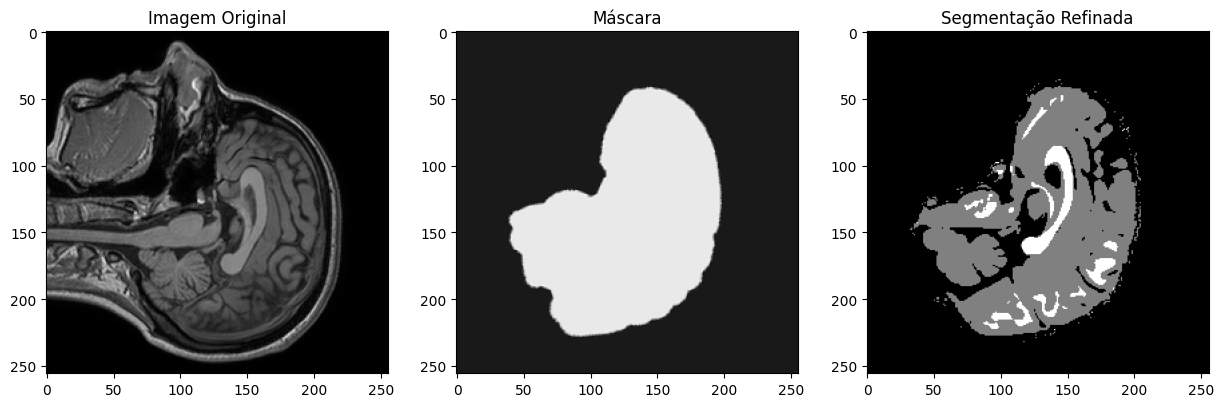

In [85]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.ndimage import label
from sklearn.cluster import KMeans

def save_segmented_image(segmented_image, output_path, original_image_path):
    """Salva a imagem segmentada no formato .nii.gz com cores específicas."""
    nii_original = nib.load(original_image_path)
    
    # Criando uma imagem colorida
    colored_image = np.zeros((*segmented_image.shape, 3), dtype=np.uint8)
    colored_image[segmented_image == 0] = [0, 0, 0]      # Fundo preto
    colored_image[segmented_image == 1] = [0, 255, 0]    # CSF - Verde
    colored_image[segmented_image == 2] = [128, 128, 128] # GM - Cinza
    colored_image[segmented_image == 3] = [255, 255, 255] # WM - Branco
    
    # Criar objeto NIfTI
    segmented_nii = nib.Nifti1Image(colored_image, nii_original.affine, nii_original.header)
    nib.save(segmented_nii, output_path)
    print(f"Imagem segmentada salva em {output_path}")

def load_nifti(file_path):
    nii = nib.load(file_path)
    data = nii.get_fdata()
    voxel_volume = np.prod(nii.header.get_zooms())
    return data, voxel_volume

def segment_gmm_with_kmeans(image, mask, n_components=3):
    """Segmenta a imagem dentro da máscara usando GMM com KMeans++ para inicialização."""
    masked_data = image[mask > 0].reshape(-1, 1)
    
    kmeans = KMeans(n_clusters=n_components, init='k-means++', random_state=42)
    kmeans.fit(masked_data)
    
    gmm = GaussianMixture(n_components=n_components, init_params='kmeans', means_init=kmeans.cluster_centers_, covariance_type='tied', n_init=10, random_state=42)
    gmm.fit(masked_data)
    
    labels = gmm.predict(masked_data)
    segmented = np.zeros_like(image, dtype=int)
    segmented[mask > 0] = labels + 1  # Ajustar para que CSF seja 1, GM seja 2 e WM seja 3
    
    # Debug: imprimir estatísticas das classes
    for i in range(n_components):
        mean_intensity = masked_data[labels == i].mean()
        print(f"Segmento {i + 1}: Média de intensidade = {mean_intensity:.2f}")
    
    return segmented

def refine_with_prob_maps(segmented_image, prob_maps):
    """Ajusta os rótulos da segmentação com base nos mapas probabilísticos."""
    refined_segmentation = np.zeros_like(segmented_image)
    mask = np.sum(prob_maps, axis=0) > 0  # Máscara onde há probabilidade definida
    
    # Para cada voxel dentro da máscara, atribuir a classe com maior probabilidade
    refined_segmentation[mask] = np.argmax(prob_maps[:, mask], axis=0) + 1  # Ajuste para classes 1,2,3
    
    return refined_segmentation

def calculate_volumes(segmented_image, mask, voxel_volume):
    """Calcula o volume de cada segmento dentro da máscara na imagem."""
    unique_labels = np.unique(segmented_image)
    volumes = {}
    
    for label in unique_labels:
        count = np.sum((segmented_image == label) & (mask > 0))
        volumes[label] = count * voxel_volume
        print(f"Segmento {label}: {volumes[label]:.2f} mm³")  # Debug: imprimir volumes
        
    return volumes

def plot_slice(image, segmented, mask, slice_idx):
    """Plota um corte da imagem original e segmentada dentro da máscara."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image[:, :, slice_idx], cmap='gray')
    axes[0].set_title("Imagem Original")
    
    axes[1].imshow(mask[:, :, slice_idx], cmap='gray')
    axes[1].set_title("Máscara")
    
    color_map = np.zeros((*segmented.shape, 3), dtype=np.uint8)
    color_map[segmented == 1] = [0, 0, 0]  # CSF - Verde
    color_map[segmented == 2] = [128, 128, 128] # GM - Cinza
    color_map[segmented == 3] = [255, 255, 255] # WM - Branco
    
    axes[2].imshow(color_map[:, :, slice_idx])
    axes[2].set_title("Segmentação Refinada")
    plt.show()

# Exemplo de uso
file_path = "images_filtered\IXI002-Guys-0828-T1.nii.gz"
mask_path = "atlas_resampled/IXI002-Guys-0828-T1.nii.gz/mni_mask.nii.gz"
prob_map_paths = ["atlas_resampled\IXI002-Guys-0828-T1.nii.gz\mni_csf.nii.gz", 
                  "atlas_resampled\IXI002-Guys-0828-T1.nii.gz\mni_gm.nii.gz", 
                  "atlas_resampled\IXI002-Guys-0828-T1.nii.gz\mni_wm.nii.gz"]

image, voxel_vol = load_nifti(file_path)
mask, _ = load_nifti(mask_path)
prob_maps = np.array([load_nifti(p)[0] for p in prob_map_paths])

segmented = segment_gmm_with_kmeans(image, mask, n_components=3)
refined_segmented = refine_with_prob_maps(segmented, prob_maps)
volumes = calculate_volumes(refined_segmented, mask, voxel_vol)

output_path = "imagem_segmentada.nii.gz"
save_segmented_image(refined_segmented, output_path, file_path)

print("Volumes Segmentados:")
for label, vol in volumes.items():
    print(f"Segmento {label}: {vol:.2f} mm³")

plot_slice(image, refined_segmented, mask, slice_idx=image.shape[2] // 2)


In [ ]:
path = "IXI002-Guys-0828-T1.nii.gz"
dicionario = calc_means_csf_gm_wm(path)
vetor_np_csf = dicionario['vetor_np_csf']
print(f'vetor_np_csf: {vetor_np_csf}')

vetor_np_gm = dicionario['vetor_np_gm']
print(f'vetor_np_gm: {vetor_np_gm}')

vetor_np_wm = dicionario['vetor_np_wm']
print(f'vetor_np_wm: {vetor_np_wm}')

num_pixels_csf = np.count_nonzero(vetor_np_csf)
print(f"Número de pixels com valor maior que zero csf: {num_pixels_csf}\n")
num_pixels_gm = np.count_nonzero(vetor_np_gm)
print(f"Número de pixels com valor maior que zero gm: {num_pixels_gm}\n")
num_pixels_wm = np.count_nonzero(vetor_np_wm)
print(f"Número de pixels com valor maior que zero wm: {num_pixels_wm}\n")

In [48]:
sorteados_csf = np.random.choice(vetor_np_csf, 300, replace=False)
sorteados_gm = np.random.choice(vetor_np_gm, 300, replace=False)
sorteados_wm = np.random.choice(vetor_np_wm, 300, replace=False)

# Unir os três conjuntos em um único vetor
vetor_total = np.concatenate((sorteados_csf, sorteados_gm, sorteados_wm)).astype(int)

In [ ]:
print(vetor_total)